In [7]:
## according to cpuworld opteron 6272 is bulldozer cpu with '16' cores. That means only 8 fpu's and 16 alus represented as 16 cores.
## And the task use fpu. L2 cache is 'shared' per 2 ALU 1 FPU (1 block). L3 is shared. According to cpuworld 2x8mB L3 points to NUMA
## 4 + 4 blocks. The task uses memory much more than calculation (~128M for 64bit double). So optimal perf is predicted at 4 threads.
## And yes there is definite dip there.

import numpy as np
import subprocess
from mpl_toolkits import mplot3d
import ipympl
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tabulate import tabulate
from tqdm import tqdm

In [8]:
x_max = 5
t_max = 10
# 3d surface work properly only when x_points == t_points
x_points = 512
t_points = 512
n_proc = 6

plt_rcount = 128
plt_ccount = 128

t_points_at_x_var = 100
x_points_start = n_proc
x_points_end = 25000
x_var_step = 1000

x_points_at_t_var = 100
t_points_start = 10
t_points_end = 25000
t_var_step = 1000

np_start = 1
np_end = 6
t_points_at_np_var = 4096
x_points_at_np_var = 4096

  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0   0.00838809     0.00571921     0.249471
     1   0.0083989      0.00294867     0.011358
     2   0.00844847     0.00356269     0.0126115
     3   0.00845808     0.00414224     0.0126093
     4   0.00847887     0.00474477     0.0138116
     5   0.00847427     0.00533822     0.0138214


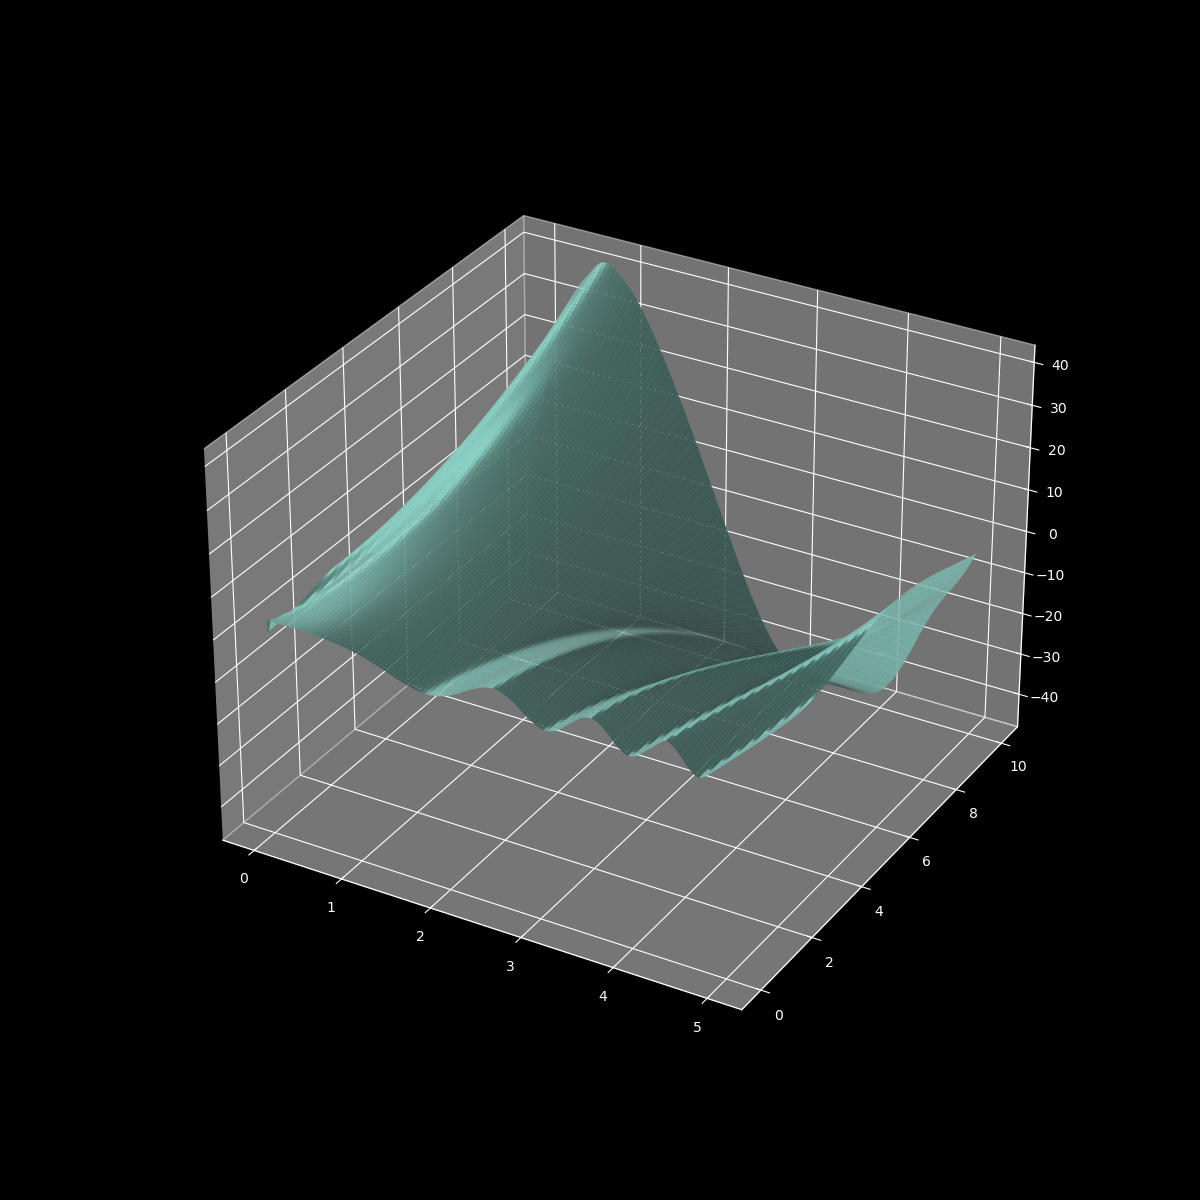

In [9]:
matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}".format (t_points)], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6       0.00129495        0.000746015        0.00162314
      1006       0.0029808         0.00227796         0.00510921
      2006       0.0107153         0.00954278         0.019713
      3006       0.0157009         0.0113123          0.0268188
      4006       0.0186019         0.0142446          0.0323945
      5006       0.0222079         0.0131984          0.0346062
      6006       0.0228576         0.0172566          0.0397236
      7006       0.0322054         0.0191965          0.0507827
      8006       0.0360535         0.0236678          0.0586263
      9006       0.0408999         0.0228             0.0625757
     10006       0.0450164         0.0223226          0.0661193
     11006       0.0465041         0.0291541          0.0751219
     12006       0.0270553         0.0189209          0.0452301
     13006       0.0560987         0.

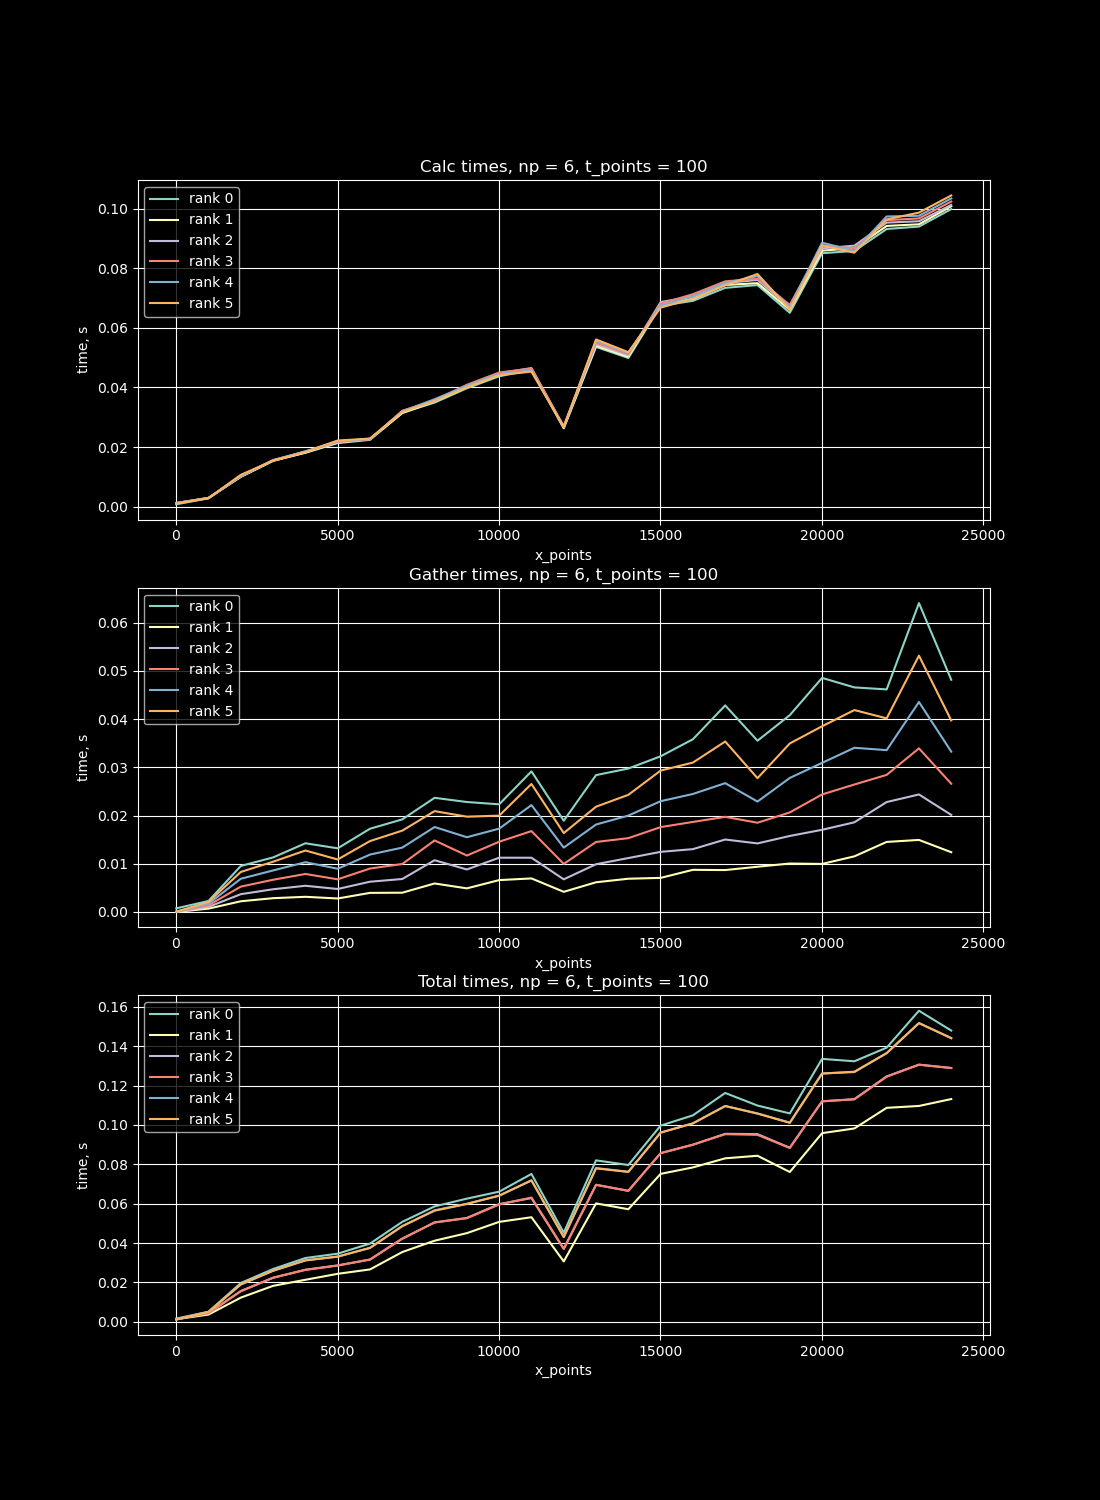

In [10]:
### x_points var at host
x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [00:11<00:00,  2.19it/s]

  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10       0.00143129        0.000193267        0.00165639
      1010       0.00873833        0.00418275         0.012919
      2010       0.0208436         0.0091159          0.0296952
      3010       0.0300638         0.00996029         0.0399222
      4010       0.0432435         0.01249            0.0557455
      5010       0.0509977         0.0139095          0.0648568
      6010       0.0584999         0.0171543          0.0756967
      7010       0.0698342         0.0188743          0.088743
      8010       0.0747681         0.0194819          0.0942837
      9010       0.084026          0.0250378          0.109069
     10010       0.0876612         0.0307436          0.118403
     11010       0.106862          0.0317742          0.138659
     12010       0.11803           0.0322755          0.150244
     13010       0.126253          0.030683

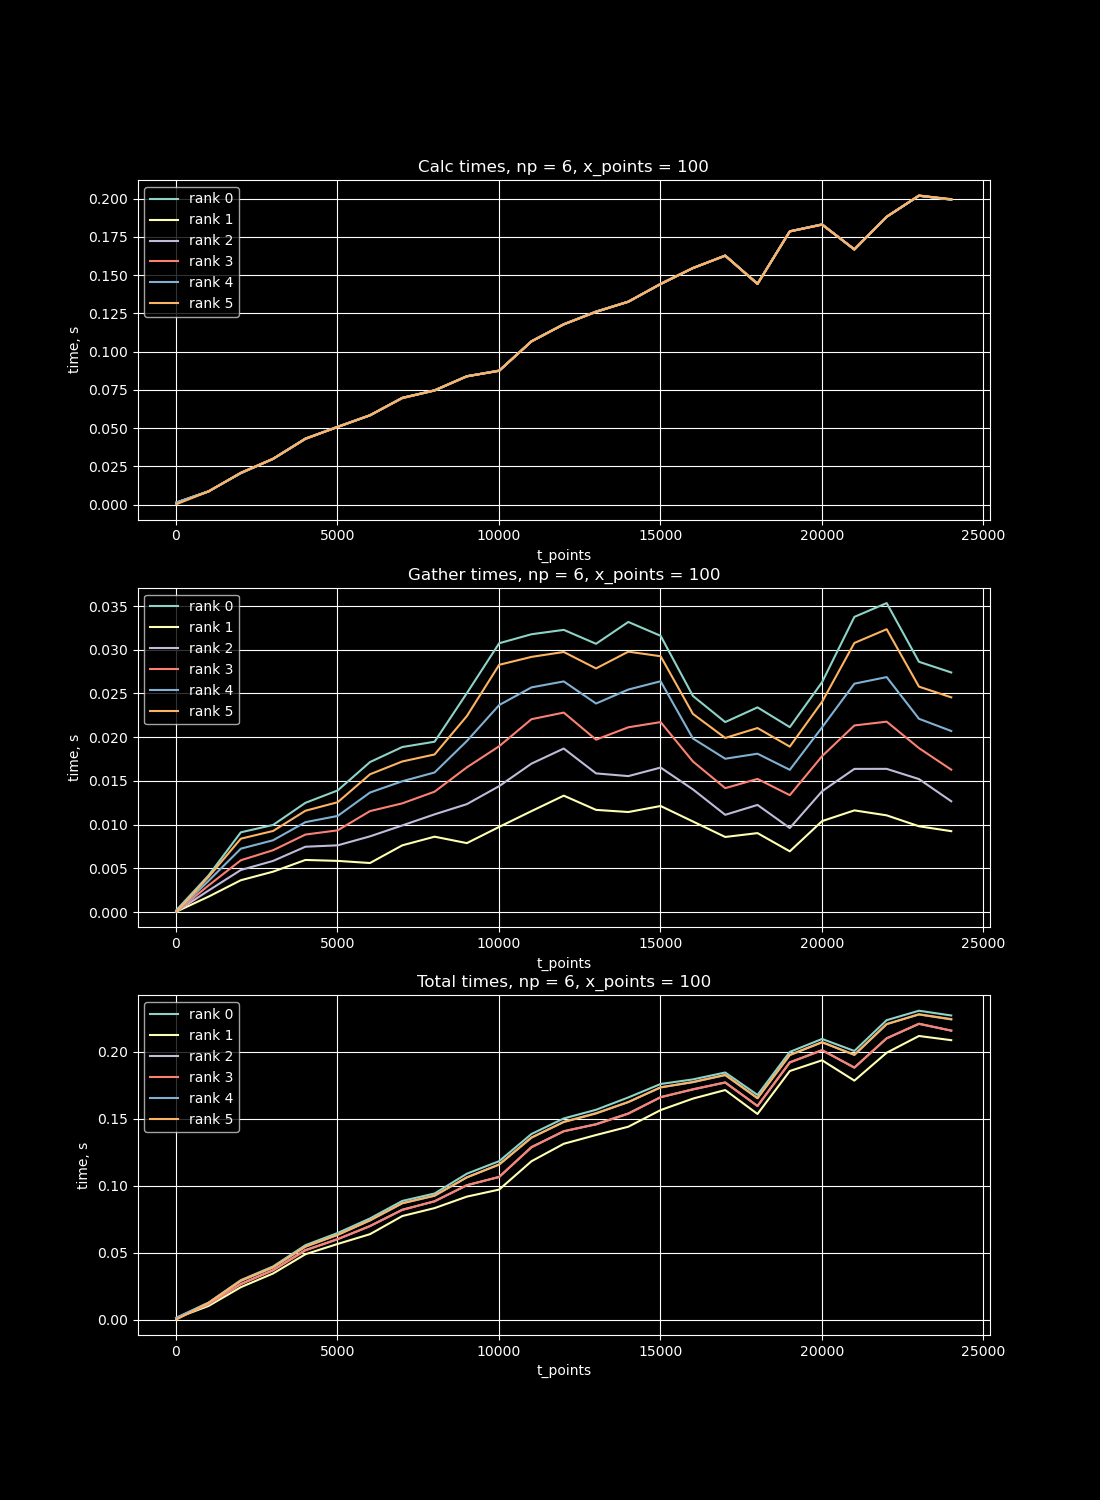

In [11]:
### t_points var at host
t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm (total = int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         1.52245            6.8e-08           1.52248
       2         0.817196           0.223729          1.04079
       3         0.531025           0.171438          0.702494
       4         0.490633           0.16768           0.658146
       5         0.524775           0.184013          0.7084
       6         0.56317            0.185088          0.747914


<StemContainer object of 3 artists>

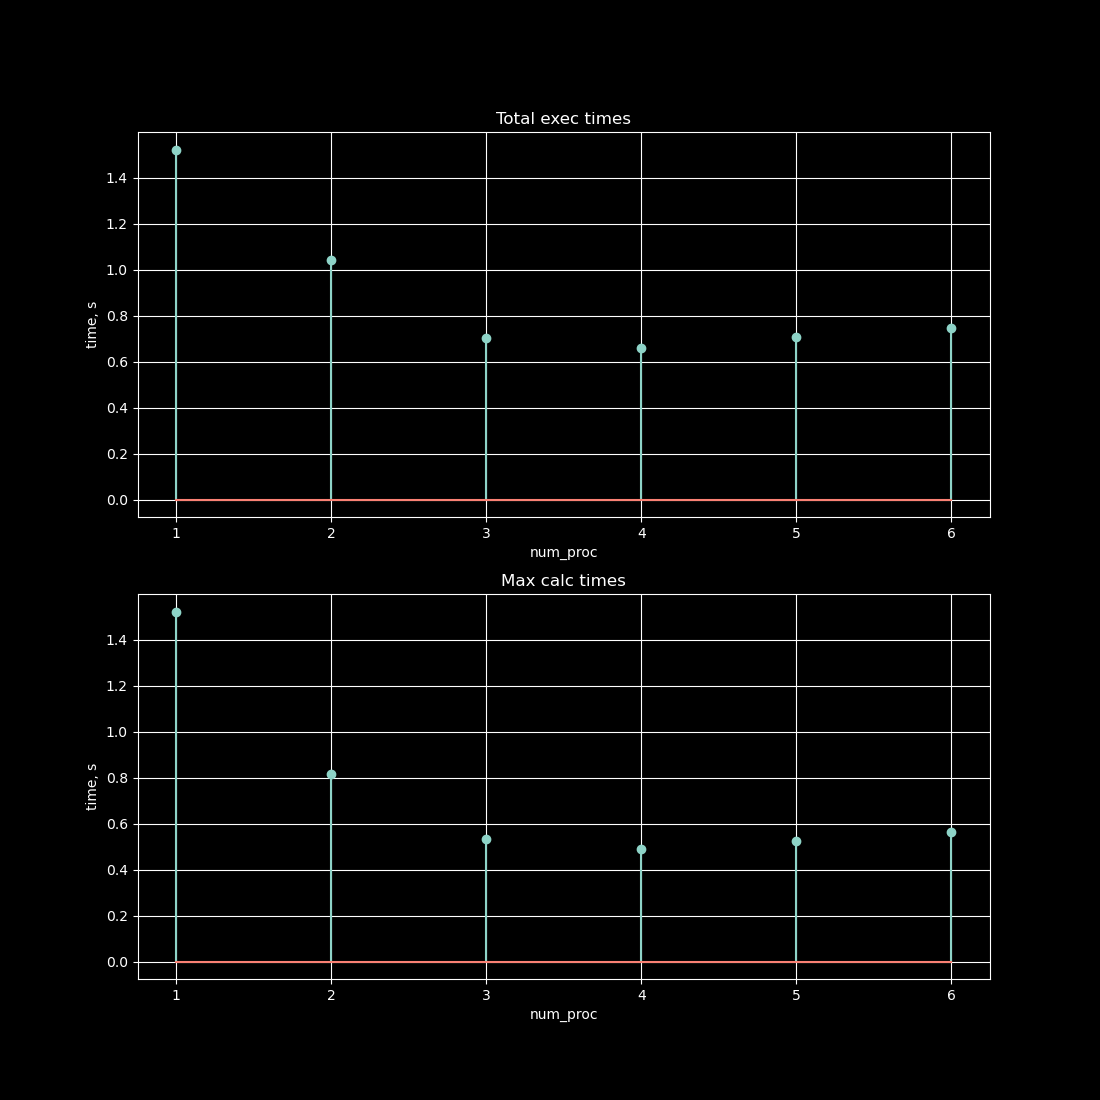

In [12]:
### np var at host

np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm (total = np_end - np_start + 1) as pbar:
    while i <= np_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (i), "./transfer", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])

<StemContainer object of 3 artists>

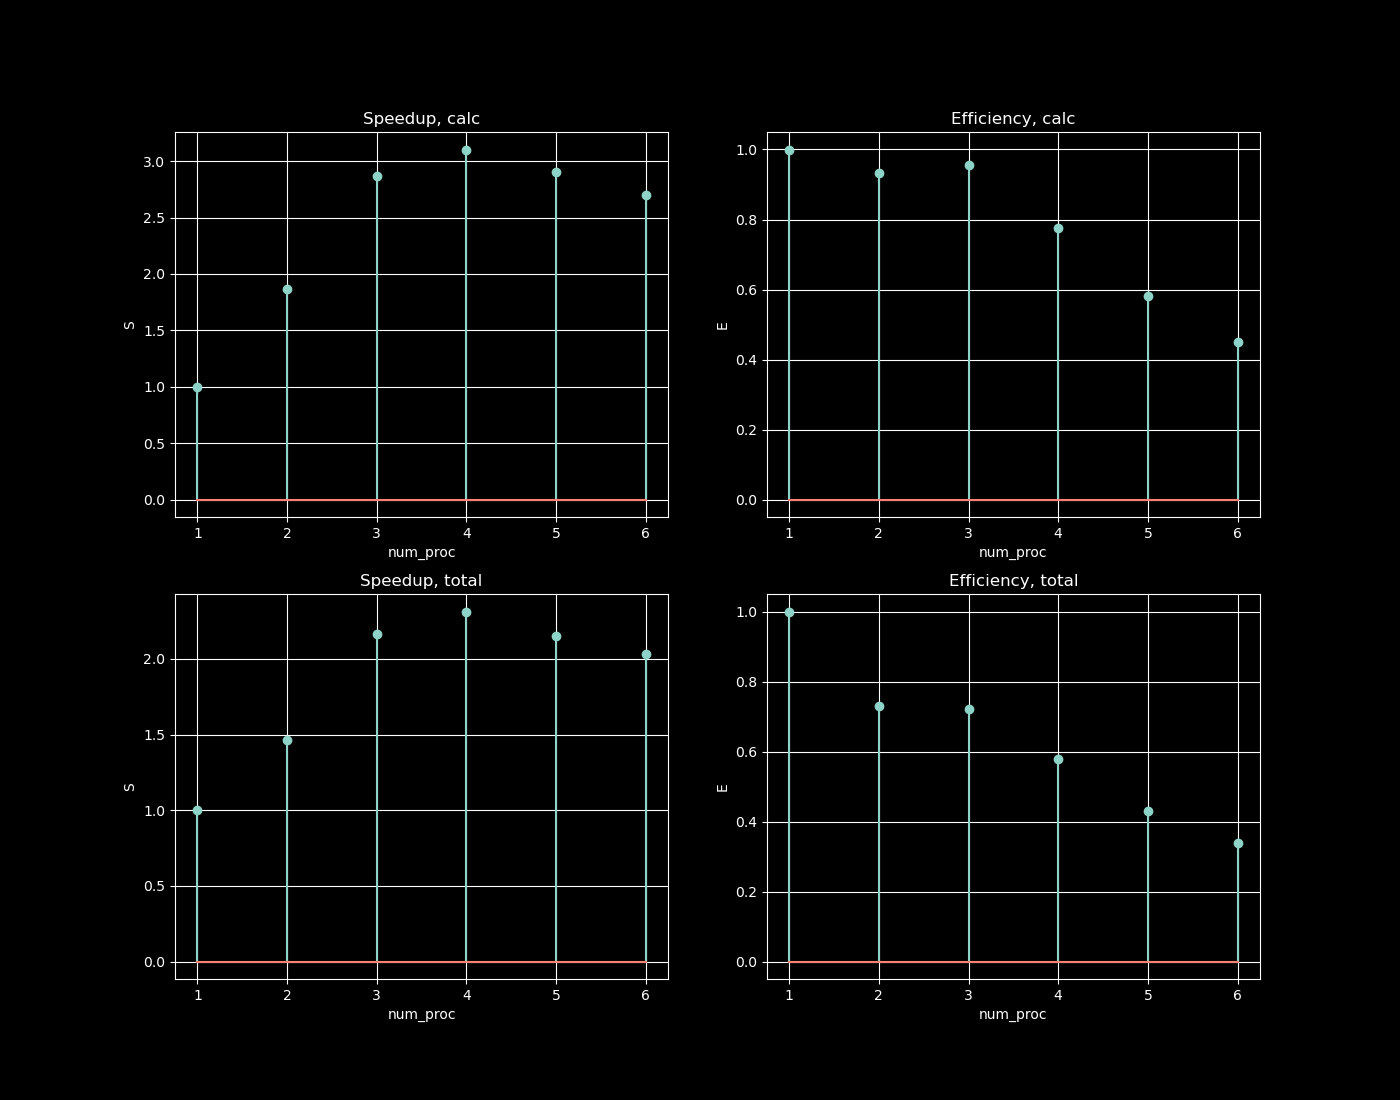

In [13]:
# Speedup & efficiency for calc
plt.figure (figsize = [14, 11])

plt.subplot (221)
plt.grid ()
plt.title ("Speedup, calc")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[0][0] / times[0])

E = times[0][0] / times[0]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (222)
plt.grid ()
plt.title ("Efficiency, calc")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

plt.subplot (223)
plt.grid ()
plt.title ("Speedup, total")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[2][0] / times[2])

E = times[2][0] / times[2]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (224)
plt.grid ()
plt.title ("Efficiency, total")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

make: Entering directory `/home/b0190302/lab1'
mpic++ "-std=c++11"  -o Lab1  main.cpp 
echo -e "\043PBS -l "walltime=00:01:00" \n\043PBS -N Lab1 \n\043PBS -q batch \ncd \044PBS_O_WORKDIR \nmpirun --hostfile \044PBS_NODEFILE "-np 4"  ./Lab1 512 512 5 10 0 512"	> job.sh 
make: Leaving directory `/home/b0190302/lab1'
make: Entering directory `/home/b0190302/lab1'
qsub -o stdout.txt ./job.sh 
157554.head.vdi.mipt.ru
make: Leaving directory `/home/b0190302/lab1'
  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0      1.77482     0.105678         2.18411
     1      1.77472     0.002877         1.77761
     2      1.76545     0.00392914       1.7694
     3      1.78477     0.095098         1.8799


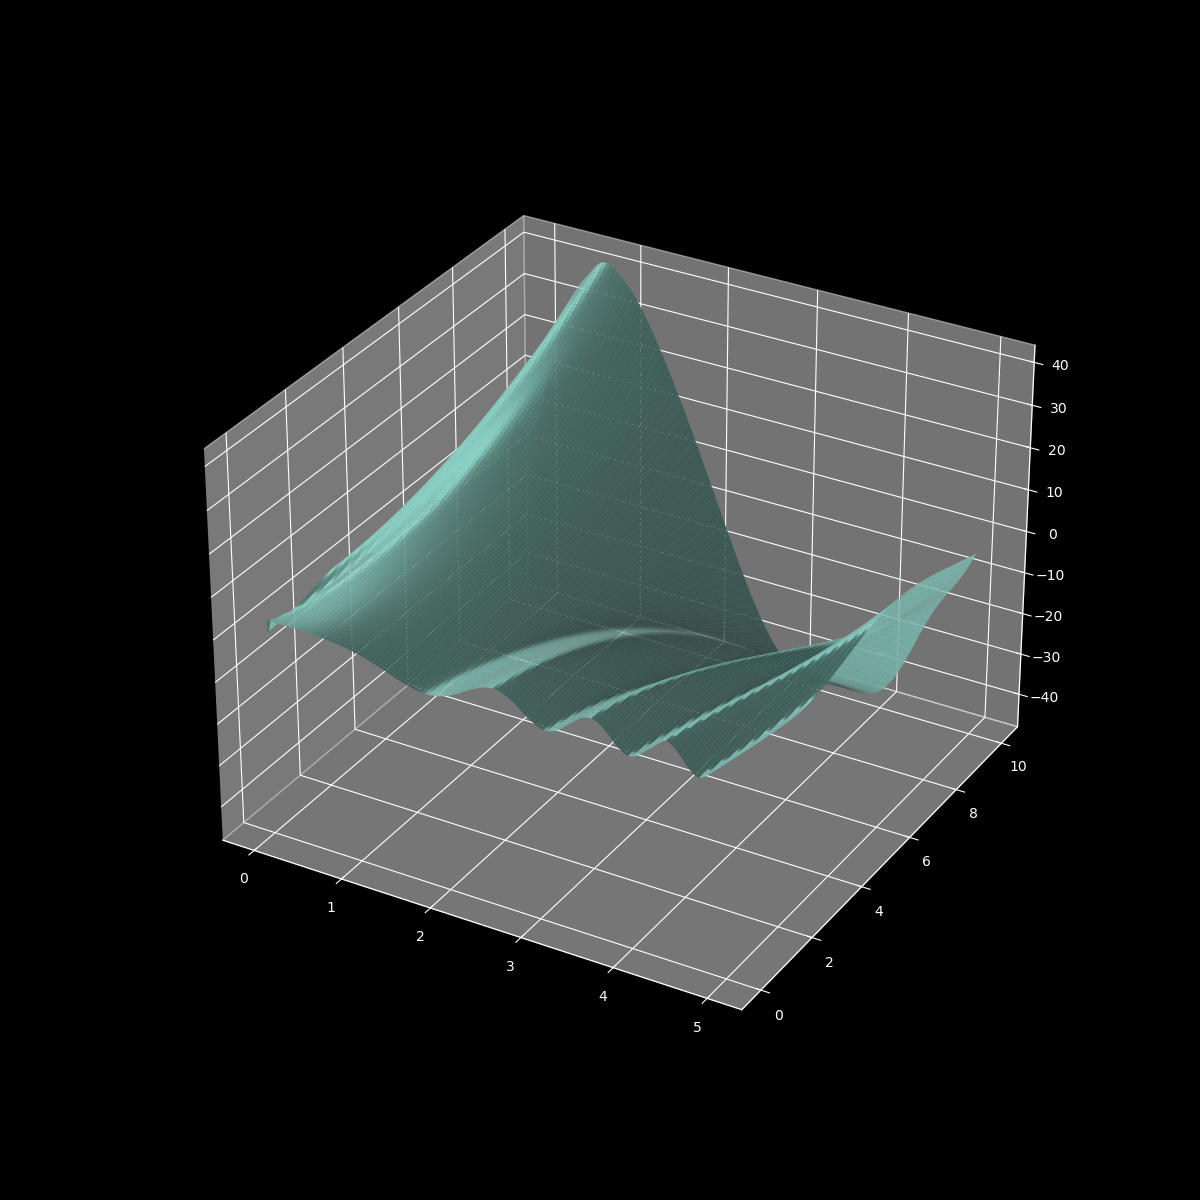

In [14]:
#### CLUSTER through ssh ####
import time
n_proc = 4
np_start = 1
np_end = 32

matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}\"".format (t_points) , "-C", "./lab1/"])
#print (compile)
time.sleep (2)
run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"])
time.sleep (4)
result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [03:48<00:00,  9.15s/it]

  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6      0.000727892        0.000241995        0.00082016
      1006      0.00480509         0.00243187         0.00725794
      2006      0.0171211          0.00422001         0.0213912
      3006      0.014797           0.00668907         0.0211821
      4006      0.022018           0.00879312         0.0301259
      5006      0.0214381          0.00994682         0.0312111
      6006      0.0288811          0.0119629          0.040451
      7006      0.0319972          0.015584           0.0469339
      8006      0.037627           0.0165701          0.0534949
      9006      0.040673           0.0194452          0.0594089
     10006      0.0954571          0.0219791          0.112219
     11006      0.0501561          0.023591           0.0729229
     12006      0.105006           0.107975           0.212263
     13006      0.327172           0.02

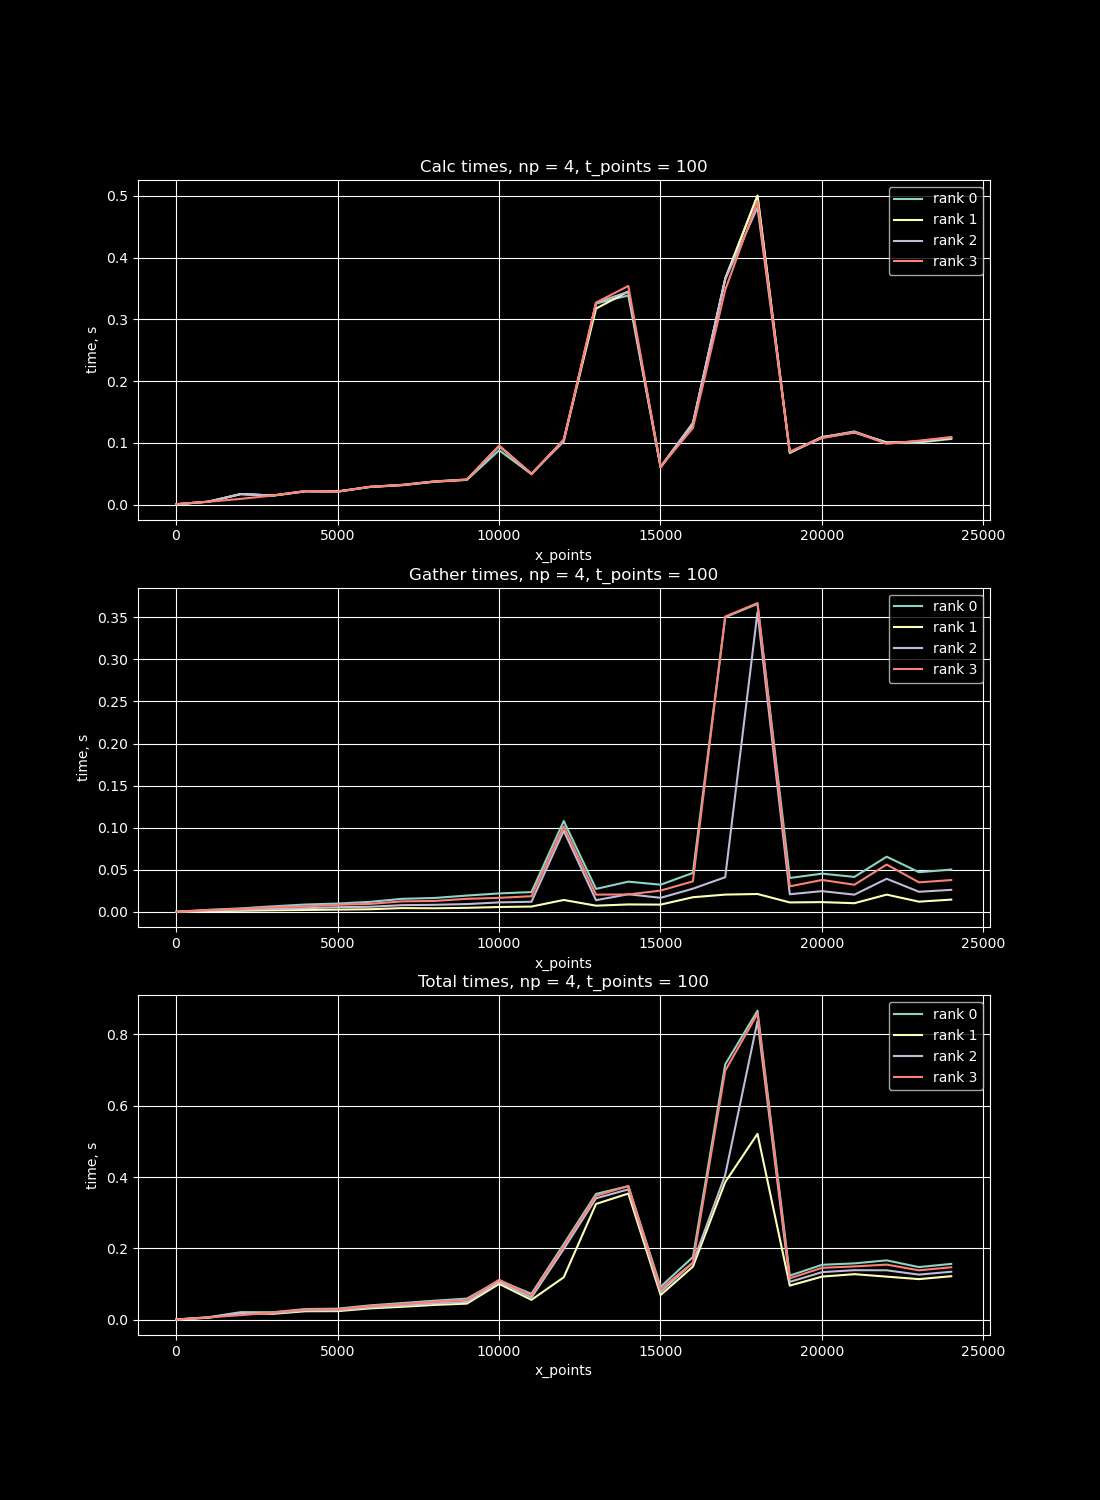

In [15]:
### x_points var at cluster

x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        #print (compile)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (4)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        #print (result)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [03:27<00:00,  8.31s/it]

  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10       0.0193851         3.50475e-05        0.0194259
      1010       0.00674701        0.0023849          0.00915599
      2010       0.0127881         0.00430703         0.017132
      3010       0.019475          0.00731802         0.026794
      4010       0.027549          0.00937915         0.036809
      5010       0.0590868         0.0131159          0.0721579
      6010       0.0406201         0.0143001          0.0547349
      7010       0.39753           0.016942           0.412493
      8010       0.39753           0.016942           0.412493
      9010       0.061352          0.022218           0.0833921
     10010       0.065665          0.024879           0.0904069
     11010       0.071913          0.0268741          0.098835
     12010       0.0726621         0.02934            0.101876
     13010       0.0798759         0.03316  

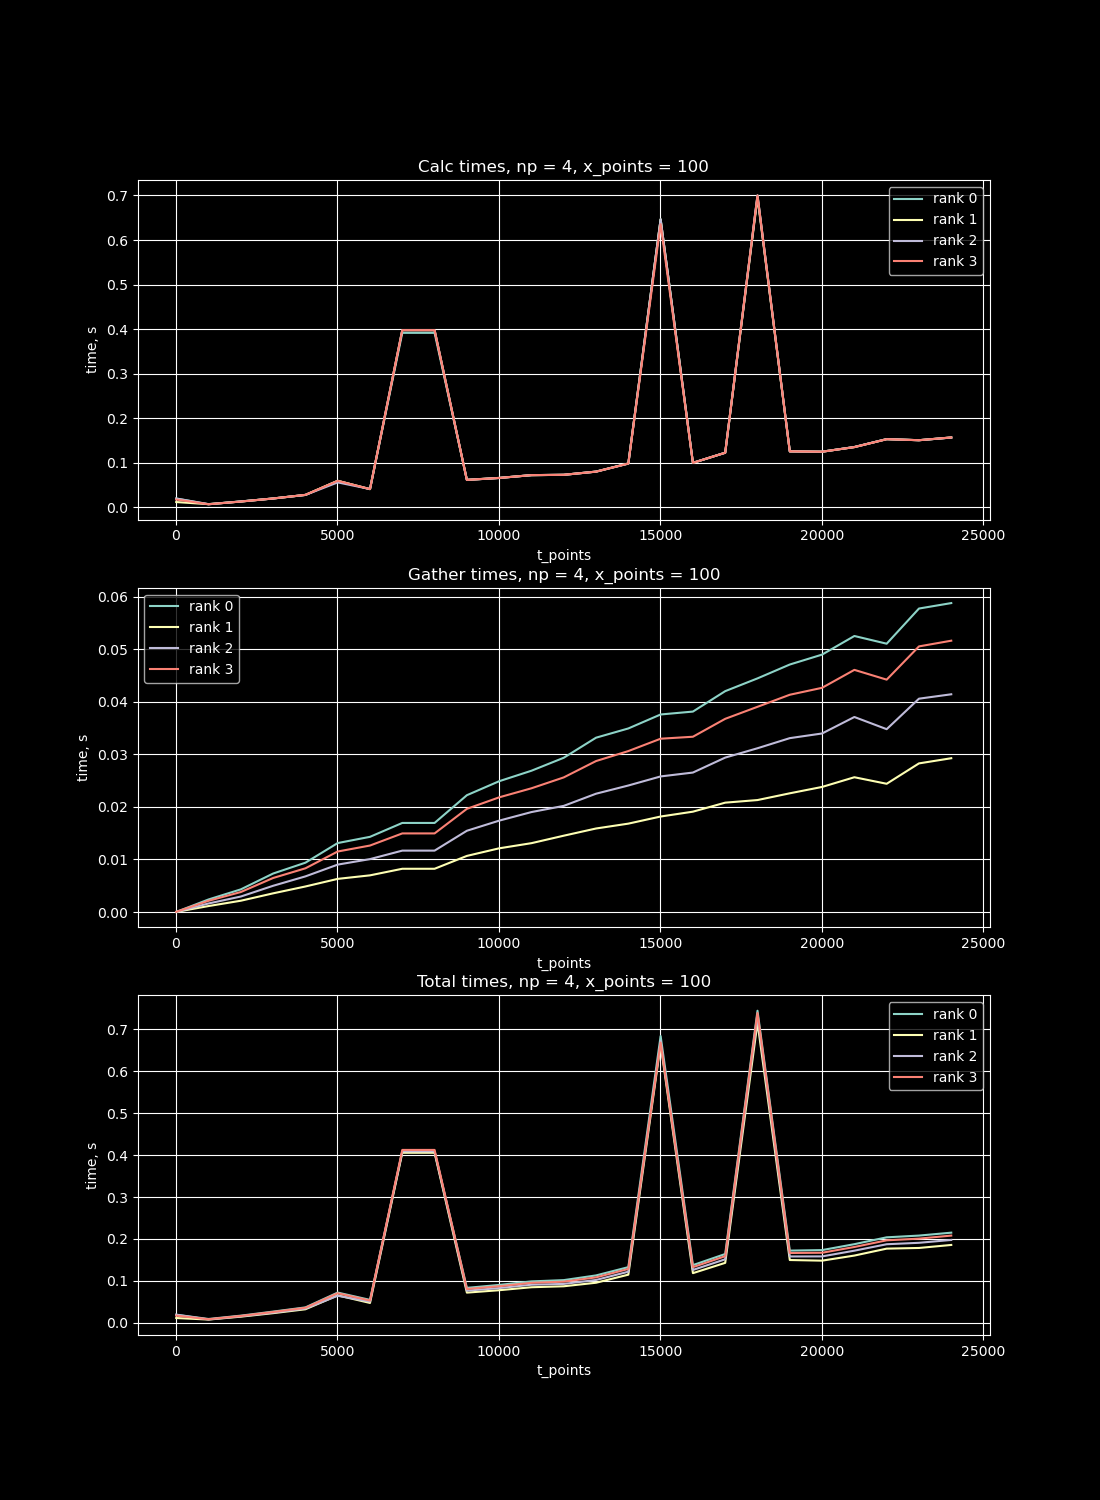

In [16]:
### t_points var at cluster

t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm(total=int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (4)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 16/16 [02:44<00:00, 10.30s/it]

  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         2.37414            0                  2.37417
       2         1.50627            0.307503           1.81344
       3         0.926783           0.353304           1.27976
       4         0.996697           0.372027           1.36848
       5         1.15946            0.403141           1.56203
       6         1.25354            0.402278           1.65554
       7         0.859352           0.589356           1.43798
       8         1.27412            0.478233           1.74121
       9         1.62808            0.621324           2.23981
      10         1.07198            0.655236           1.72421
      11         1.10107            0.897228           1.98805
      12         1.30866            1.22998            2.53318
      13         1.7211             1.77069            3.47791
      14         1.69959            0.8335             

<StemContainer object of 3 artists>

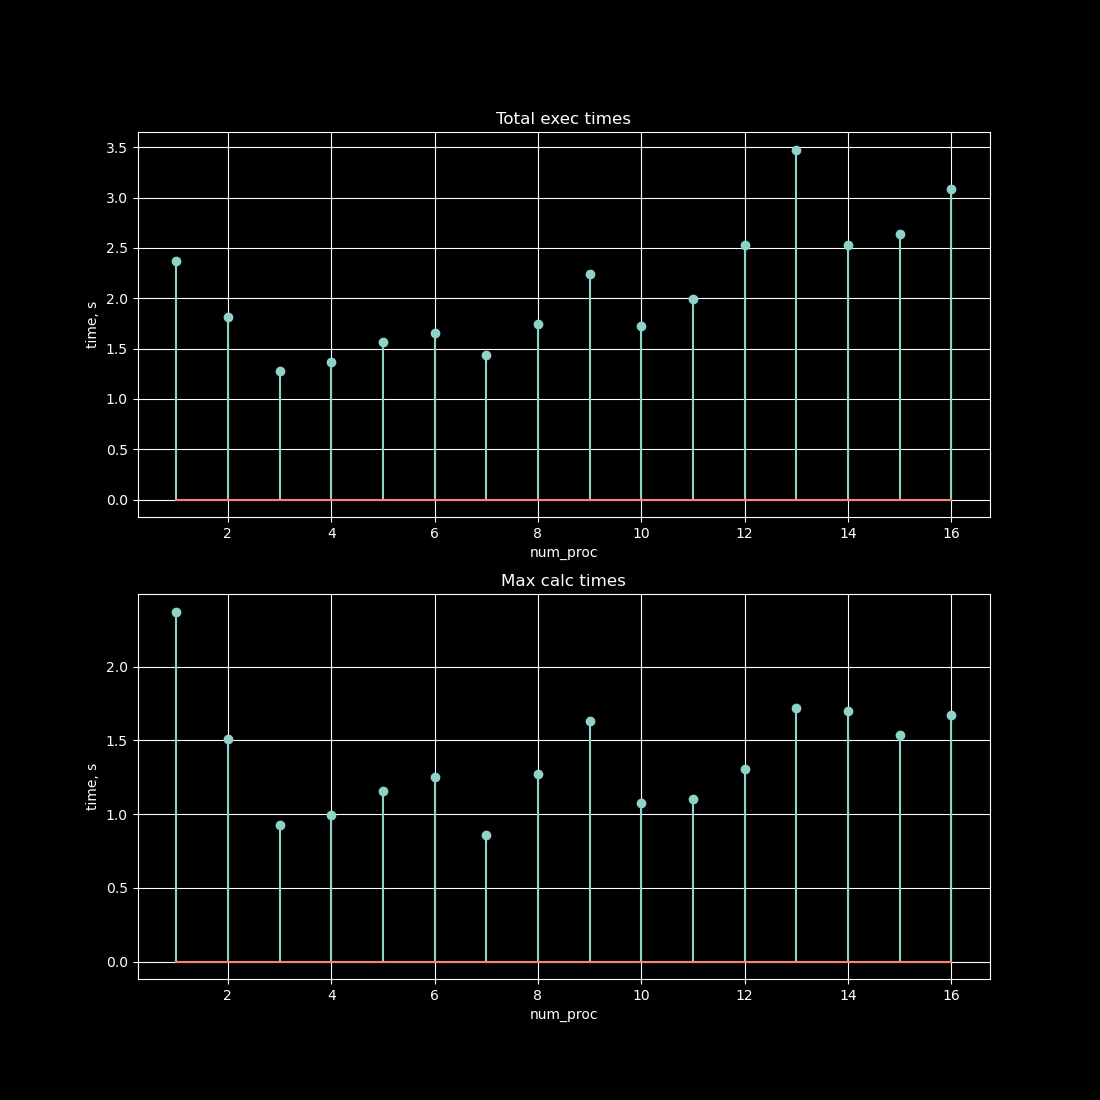

In [17]:
### np var at cluster
np_end = 16
np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm(total = np_end - np_start + 1) as pbar:
    while i <= np_end: 
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (i), "ARGS=\"", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (6)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])

<StemContainer object of 3 artists>

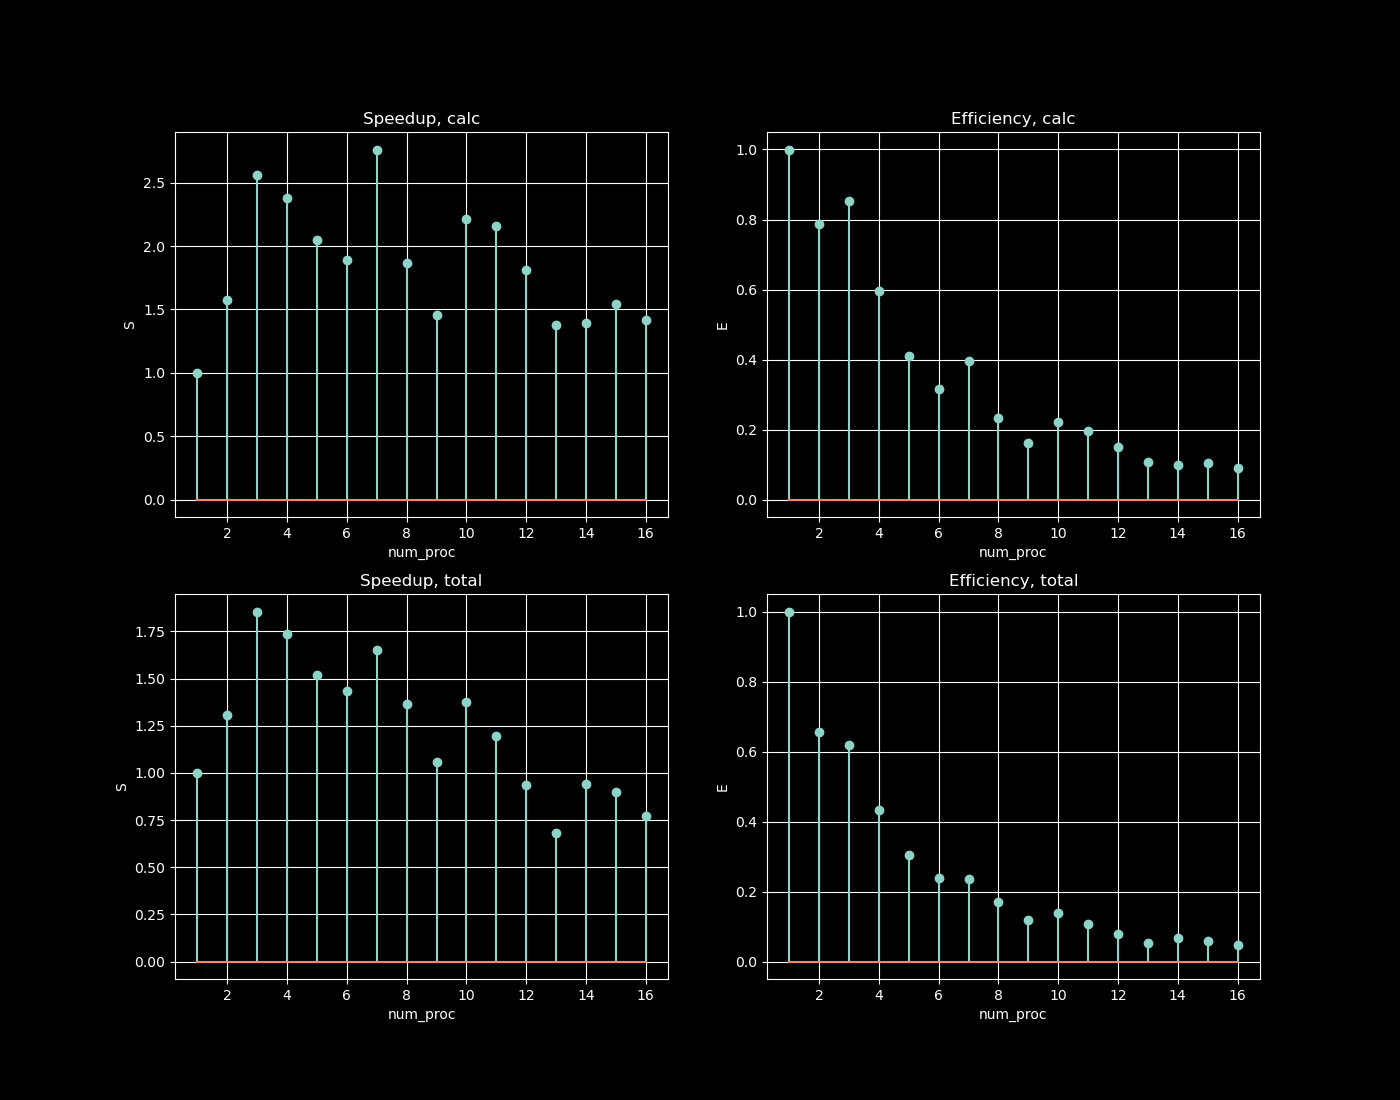

In [18]:
# Speedup & efficiency for calc
plt.figure (figsize = [14, 11])

plt.subplot (221)
plt.grid ()
plt.title ("Speedup, calc")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[0][0] / times[0])

E = times[0][0] / times[0]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (222)
plt.grid ()
plt.title ("Efficiency, calc")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

plt.subplot (223)
plt.grid ()
plt.title ("Speedup, total")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[2][0] / times[2])

E = times[2][0] / times[2]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (224)
plt.grid ()
plt.title ("Efficiency, total")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)